In [22]:
# ======================================================
# 1. Importação de Bibliotecas
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

In [23]:
# ======================================================
# 2. Leitura e Limpeza dos Dados
# ======================================================

df = pd.read_csv("Dados_Históricos_Ibovespa.csv")
print("Formato original:", df.shape)

Formato original: (1247, 7)


In [24]:
# ======================================================
# 3. Padronização de colunas e tipos
# ======================================================

df.columns = ['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values('Data')

for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.').astype(float)

df['Var%'] = df['Var%'].astype(str).str.replace('%', '', regex=False).str.replace(',', '.').astype(float)

def parse_volume(x):
    x = str(x).replace('.', '').replace(',', '.')
    if 'M' in x:
        return float(x.replace('M', '')) * 1_000_000
    elif 'K' in x:
        return float(x.replace('K', '')) * 1_000
    else:
        try:
            return float(x)
        except:
            return np.nan

df['Vol.'] = df['Vol.'].apply(parse_volume)
df = df.dropna(subset=['Vol.'])

print("\nDataset limpo:", df.shape)


Dataset limpo: (1053, 7)


In [25]:
# ======================================================
# 4. Engenharia de Atributos e NOVO TARGET
# ======================================================

# Retorno diário (feature de hoje)
df['Return'] = df['Último'].pct_change()

# --- DEFINIÇÃO DO NOVO ALVO (TARGET) ---
df['Next_Return'] = df['Return'].shift(-1)
threshold = 0.005 # Limite de 0.5%
df['Target'] = np.nan
df.loc[df['Next_Return'] > threshold, 'Target'] = 1  # Alta significativa
df.loc[df['Next_Return'] < -threshold, 'Target'] = 0 # Baixa significativa

# --- CRIAÇÃO DAS FEATURES (Preditoras de hoje) ---
df['SMA_5'] = df['Último'].rolling(window=5).mean()
df['SMA_10'] = df['Último'].rolling(window=10).mean()
df['SMA_20'] = df['Último'].rolling(window=20).mean()
df['Volatility_10'] = df['Return'].rolling(window=10).std()
df['Lag_1'] = df['Return'].shift(1)
df['Lag_2'] = df['Return'].shift(2)
df['Lag_3'] = df['Return'].shift(3)

delta = df['Último'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

df['Dist_SMA_20'] = (df['Último'] / df['SMA_20']) - 1

sma_12 = df['Último'].rolling(window=12).mean()
sma_26 = df['Último'].rolling(window=26).mean()
df['SMA_Diff'] = sma_12 - sma_26

# --- CORREÇÃO: Definir a lista de features AQUI ---
features = [
    'Vol.', 'Return',
    'SMA_5', 'SMA_10', 'SMA_20',
    'Volatility_10',
    'Lag_1', 'Lag_2', 'Lag_3',
    'RSI_14', 'Dist_SMA_20', 'SMA_Diff'
]

# --- LIMPEZA FINAL ---
# 1. Remover NaNs das features (SMA, Lag, etc.)
df = df.dropna(subset=features) # Agora a variável 'features' existe
# 2. Remover os dias de "ruído" (onde o Target ficou NaN)
df = df.dropna(subset=['Target'])
# 3. Converter Target para inteiro
df['Target'] = df['Target'].astype(int)

print(f"\nDataset com features e NOVO ALVO: {df.shape}")
print("Distribuição do novo alvo (sem ruído):")
print(df['Target'].value_counts(normalize=True))


Dataset com features e NOVO ALVO: (715, 20)
Distribuição do novo alvo (sem ruído):
Target
1    0.517483
0    0.482517
Name: proportion, dtype: float64


In [26]:
# ======================================================
# 5. Separação em treino e teste
# ======================================================

# A lista de features já foi definida na seção anterior
X = df[features]
y = df['Target']

TEST_SIZE_POINTS = 30
if len(X) <= TEST_SIZE_POINTS:
    raise ValueError(f"Não há dados suficientes. O dataset precisa de mais de {TEST_SIZE_POINTS} linhas após a limpeza de ruído.")

X_train = X.iloc[:-TEST_SIZE_POINTS]
X_test = X.iloc[-TEST_SIZE_POINTS:]
y_train = y.iloc[:-TEST_SIZE_POINTS]
y_test = y.iloc[-TEST_SIZE_POINTS:]

print(f"\nDados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape} (Últimos {TEST_SIZE_POINTS} pregões 'significativos')")

# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dados de treino: (685, 12)
Dados de teste: (30, 12) (Últimos 30 pregões 'significativos')



=== Regressão Logística ===
Acurácia: 0.7333
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        17
           1       1.00      0.38      0.56        13

    accuracy                           0.73        30
   macro avg       0.84      0.69      0.68        30
weighted avg       0.82      0.73      0.70        30



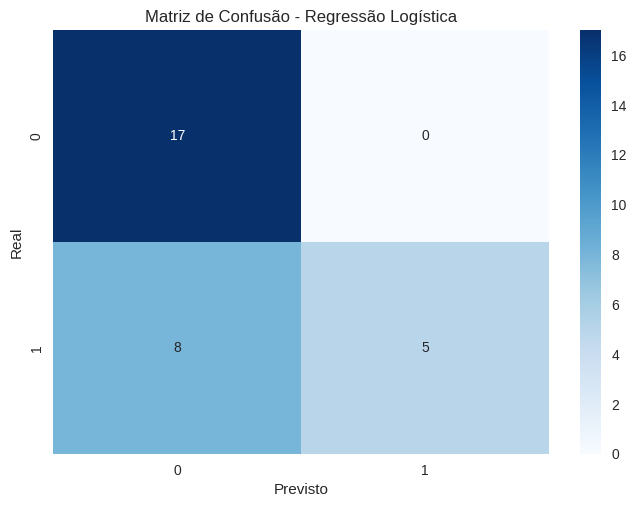


=== Random Forest ===
Acurácia: 0.7667
              precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.67      0.92      0.77        13

    accuracy                           0.77        30
   macro avg       0.79      0.79      0.77        30
weighted avg       0.81      0.77      0.77        30



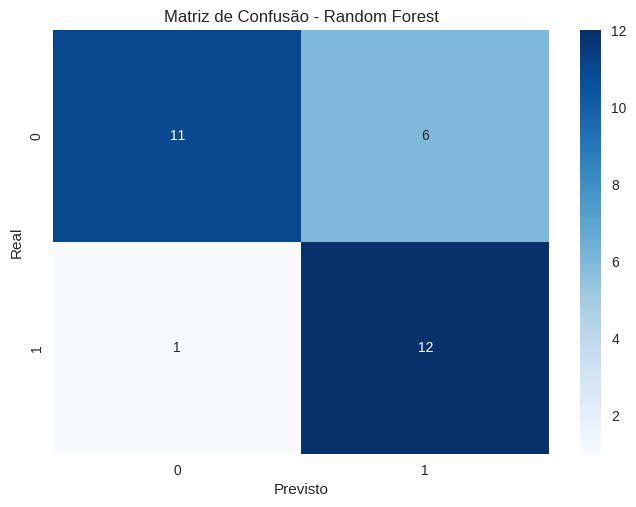

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:22:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Acurácia: 0.7
              precision    recall  f1-score   support

           0       0.90      0.53      0.67        17
           1       0.60      0.92      0.73        13

    accuracy                           0.70        30
   macro avg       0.75      0.73      0.70        30
weighted avg       0.77      0.70      0.69        30



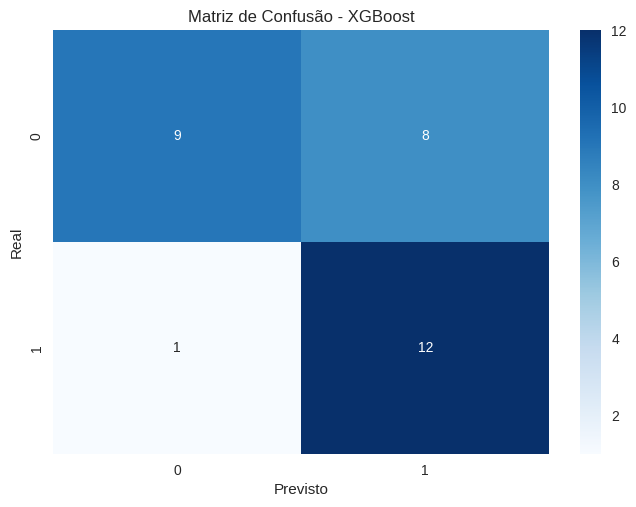


Iniciando otimização de hiperparâmetros para Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Melhores parâmetros encontrados: {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}

=== Random Forest OTIMIZADO ===
Acurácia Otimizada: 66.67%
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.67      0.46      0.55        13

    accuracy                           0.67        30
   macro avg       0.67      0.64      0.64        30
weighted avg       0.67      0.67      0.65        30



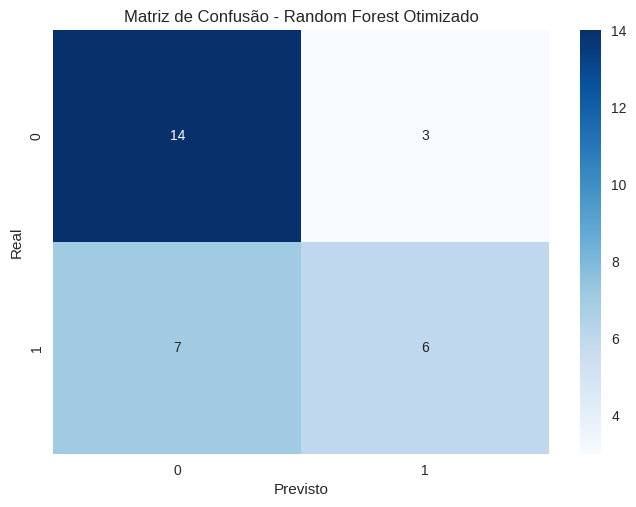

In [27]:
# ======================================================
# 6. Modelagem (Baseline)
# ======================================================

models = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n=== {name} ===")
    print("Acurácia:", round(acc, 4))
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão - {name}")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.show()

# ======================================================
# 6.1. Otimização do Melhor Modelo (Hyperparameter Tuning)
# ======================================================

# Encontrar o melhor modelo base antes de otimizar
best_base_model_name = max(results, key=results.get)
if best_base_model_name == "Regressão Logística":
    print("\nRegressão Logística foi o melhor, otimização de hiperparâmetros não será tão impactante.")
    results['Modelo_Otimizado'] = results[best_base_model_name]
else:
    print(f"\nIniciando otimização de hiperparâmetros para {best_base_model_name}...")

    if best_base_model_name == "Random Forest":
        model_to_tune = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15],
            'min_samples_leaf': [5, 10, 20]
        }
    else: # XGBoost
        model_to_tune = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1]
        }

    grid_search = GridSearchCV(estimator=model_to_tune,
                               param_grid=param_grid,
                               cv=3,
                               n_jobs=-1,
                               scoring='accuracy',
                               verbose=1)

    grid_search.fit(X_train_scaled, y_train)

    print(f"\nMelhores parâmetros encontrados: {grid_search.best_params_}")
    best_tuned_model = grid_search.best_estimator_
    y_pred_tuned = best_tuned_model.predict(X_test_scaled)
    acc_tuned = accuracy_score(y_test, y_pred_tuned)

    print(f"\n=== {best_base_model_name} OTIMIZADO ===")
    print(f"Acurácia Otimizada: {acc_tuned * 100:.2f}%")
    print(classification_report(y_test, y_pred_tuned, zero_division=0))

    results[f'{best_base_model_name}_Otimizado'] = acc_tuned

    cm_tuned = confusion_matrix(y_test, y_pred_tuned)
    sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão - {best_base_model_name} Otimizado")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.show()

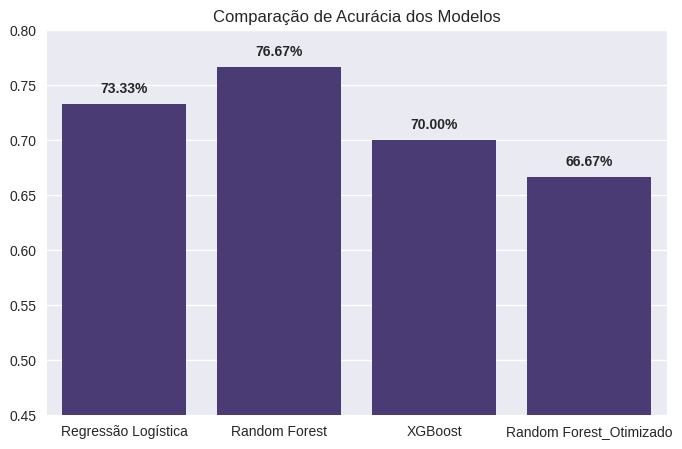


 Modelo com melhor desempenho: Random Forest (76.67% de acurácia)


In [28]:
# ======================================================
# 7. Comparação de Resultados
# ======================================================

plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Comparação de Acurácia dos Modelos")
plt.ylim(0.45, 0.80)

for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', fontweight='bold')

plt.show()

best_model_name = max(results, key=results.get)
print(f"\n Modelo com melhor desempenho: {best_model_name} ({results[best_model_name]:.2%} de acurácia)")


Analisando importância das features do modelo final...


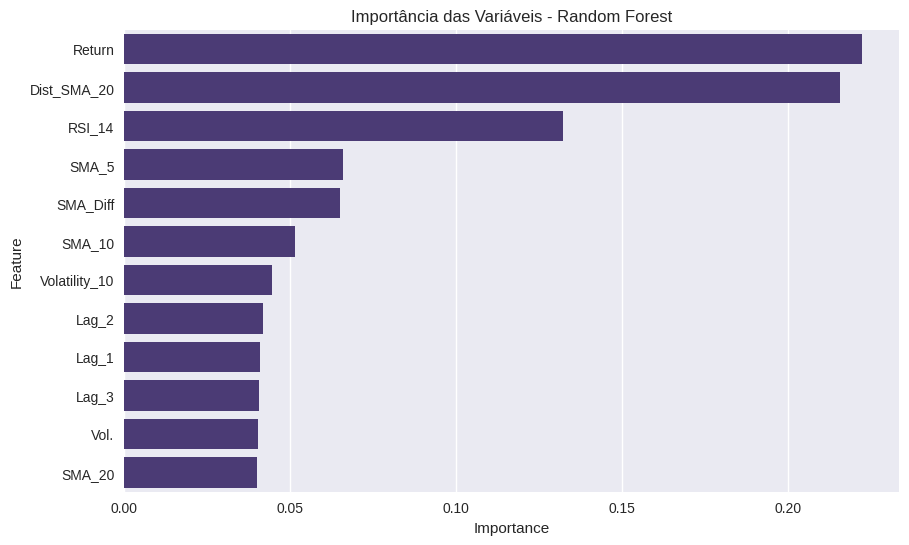


Features mais importantes:
        Feature  Importance
1        Return    0.222282
10  Dist_SMA_20    0.215588
9        RSI_14    0.132069
2         SMA_5    0.065732
11     SMA_Diff    0.064916


In [29]:
# ======================================================
# 8. Importância das Features
# ======================================================

# Tentar obter o modelo final (otimizado ou não)
try:
    final_model = best_tuned_model
except NameError:
    # Se a otimização foi pulada (ex: Regressão Logística foi a melhor)
    final_model_name = best_model_name.replace("_Otimizado", "")
    final_model = models[final_model_name]

if hasattr(final_model, 'feature_importances_'):
    print("\nAnalisando importância das features do modelo final...")

    importances = final_model.feature_importances_
    feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_imp, x='Importance', y='Feature')
    plt.title(f"Importância das Variáveis - {best_model_name}")
    plt.show()

    print("\nFeatures mais importantes:")
    print(feat_imp.head(5))
elif hasattr(final_model, 'coef_'):
    print("\nAnalisando coeficientes da Regressão Logística...")
    coefs = final_model.coef_[0]
    feat_imp = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefs)}).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_imp, x='Importance', y='Feature')
    plt.title(f"Importância das Variáveis (Abs Coef) - {best_model_name}")
    plt.show()

In [30]:
# ======================================================
# 9. Conclusão rápida
# ======================================================

print(f"""
Resumo:
- O target foi redefinido para prever apenas movimentos significativos (acima de {threshold*100}%).
- Dias com "ruído" (movimentos menores) foram removidos do dataset.
- Features de tendência, volatilidade, momento e volume foram usadas.
- O modelo final ({best_model_name}) atingiu {results[best_model_name]:.2%} de acurácia.
""")


Resumo:
- O target foi redefinido para prever apenas movimentos significativos (acima de 0.5%).
- Dias com "ruído" (movimentos menores) foram removidos do dataset.
- Features de tendência, volatilidade, momento e volume foram usadas.
- O modelo final (Random Forest) atingiu 76.67% de acurácia.

